## Visualization of real microbiome datasets using CKDR

Ternary visualization requires the Python package `ternary`
- You can install it through `pip install python-ternary`
- Documentation: https://github.com/marcharper/python-ternary

In [1]:
import os, sys
os.chdir('..')
sys.path.insert(0, os.path.abspath('..'))
import pickle

import numpy as np
import pandas as pd
import torch

# Plot helpers
import ternary
from functions.plot_helper import corner_labeling, tern_scatter_decbdry, tern_scatter_cmap
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
marker_list=['o', 'x']

# Cross-validation -> training functions
from functions.cross_val import ckdr_cv_parallel

# Collapse warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
MASTER_SEED = 20241225

In [2]:
directory = "./datasets/MLRepo/"
x_dir = "/refseq/taxatable.txt"
y_dir = "/task-"  
y_names = {"gevers": "ileum", "ravel": "nugent-score"}

# HMP data (Sections 1-2)
Dataset downloaded from the repository: https://github.com/diegotomassi/sdr4comp
- Paper: Tomassi et al. (2021) ["Sufficient dimension reduction for compositional data"](https://academic.oup.com/biostatistics/article/22/4/687/5689688)

In [3]:
# Load HMP data
compos = pd.read_csv("datasets/HMP/HMPdataL2.txt", header=None)
totals = pd.read_csv("datasets/HMP/HMPdataL2reads.txt", header=None)
labels = pd.read_table("datasets/HMP/HMPlabels.txt", header=None)

counts = np.round(np.array(compos) * np.array(totals))
groups = [None, 'Stool','Saliva','Skin','Nasal','Vagina'] # None for dummy indexing

Y = list()
for i in range(len(labels)):
    Y.append(groups[labels[0][i]])
Y = np.array(Y)

X = np.array(compos)
# Delete taxa less than "or equal to" 5 counts: consistent with the processing in Tomassi et al. (2021)
X = X[:, counts.sum(0) > 5]  
X = X / X.sum(1)[:, None]

print("Zero ratio:", np.sum(X == 0.) / X.size)
print("(Num_samples, Num_taxa) =", X.shape)

Zero ratio: 0.7348528378982315
(Num_samples, Num_taxa) = (681, 23)


In [ ]:
# 90 sec with 50 cores (reduce as needed)
result = ckdr_cv_parallel(X, Y, type_Y="multiclass", folds=5, verbose=True,
                          epsilon_list=[0.001, 0.01],
                          sigma_list=np.geomspace(1/2, 2., 5),
                          n_jobs=50, 
                          seed=MASTER_SEED,
                          )
# Save the result
with open("results/ternary_train/HMP.pkl", "wb") as f:
    pickle.dump(result, f)

Running parallel cross-validation with 10 parameter combinations across 5 folds, totaling 50 individual training tasks.


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   6 out of  50 | elapsed:   35.4s remaining:  4.3min
[Parallel(n_jobs=50)]: Done  17 out of  50 | elapsed:   52.9s remaining:  1.7min
[Parallel(n_jobs=50)]: Done  28 out of  50 | elapsed:  1.0min remaining:   47.7s
[Parallel(n_jobs=50)]: Done  39 out of  50 | elapsed:  1.2min remaining:   20.3s
[Parallel(n_jobs=50)]: Done  50 out of  50 | elapsed:  1.5min finished


\nSelected parameters after 5-fold Cross-validation (parallel):
  target_dim = 3, epsilon = 0.001, sigma_Z = 0.3408
  Corresponding mean CV score: 0.2191
\nRefitting model with selected best parameters on the full dataset (parallel CV)...
Starting Projected Gradient Descent on device: cpu
  n_samples=681, n_features=23, target_dim=3
  sigma=0.3408, epsilon=0.0010, initial_lr=1.00e+00, tol=1.0e-03
Iter:    0, Obj: 250.809586, LR: 1.60e+01, update amount ||P_new - P_old||/LR: 2.40e-01
Iter:   50, Obj: 226.114075, LR: 3.91e-03, update amount ||P_new - P_old||/LR: 2.62e-01
Converged at iteration 77: Change in objective value below tolerance.


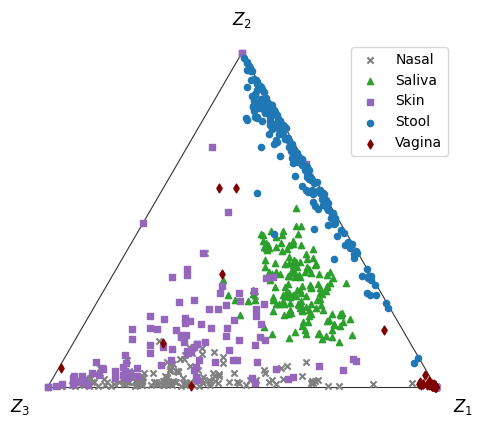

In [52]:
# Load the trained result
with open("results/ternary_train/HMP.pkl", "rb") as f:
    result = pickle.load(f)

P = result['CV_fitted_P'].numpy()
P[[1, 2]] = P[[2, 1]] # row exchange for visual compatibility
Z = (X @ P.T)

figure, tax = ternary.figure(scale=1)
tax.boundary(linewidth=0.8, alpha=0.8, zorder=1)

# Color and markers
color_list = [None, 'tab:blue', 'tab:green', 'tab:purple', 'gray', 'maroon']
marker_list = [None, 'o', '^', 's', 'x', 'd']

# Scatter plots
for i in [4, 2, 3, 1, 5]:
    tax.scatter(Z[Y == groups[i]], marker=marker_list[i], color=color_list[i], label=groups[i], s=20)

tax.legend()
corner_labeling(tax)

figure.set_size_inches(5.5, 5, forward=True) # Size forcing
tax.savefig("results/images/HMP", dpi=400, bbox_inches='tight')
tax.show()

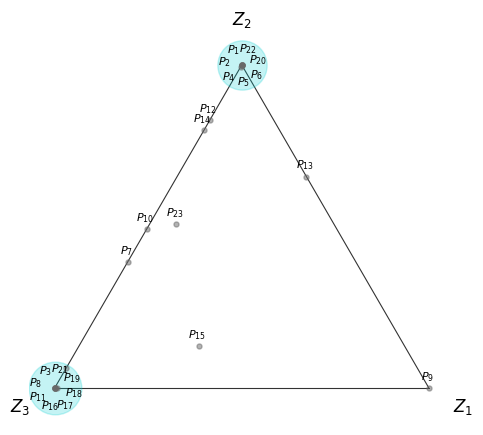

In [ ]:
from functions.plot_helper import symmetric_radial_positions

# Variable allocation plot
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=0.8, alpha=0.8, zorder=1)
tax.scatter(P.T, 
            c="dimgray",
            # c="darkblue", # alpha=0.27 
            marker='o', s=13, alpha=0.5,
             zorder=3)

# Make bubbles at the corners
# Bubbles for visual indication of overlappings at vertices (90% threshold?)
threshold = 0.9
s = 180
power = 1
non_annot = {}
for j in range(1, 3):
    # Positions of the columns which lie near the j-th vertex
    pos = np.where(P[j, :] > threshold)[0]
    if len(pos) > 0:
        # Store
        non_annot[j] = pos

        # bubble size
        size = s * len(pos) ** power
        # Vertex position
        vert = np.zeros((1, 3))
        vert[:, j] = 1.0
        # Plot large bubble
        tax.scatter(vert, c="darkturquoise", marker='o', s=size, alpha=0.23, zorder=2)

        # Add column names symmetrically
        radius = 0.0065 + 0.0057 * len(pos) # radius of the annotation texts
        positions = symmetric_radial_positions(vert[0], radius, len(pos))
        for i, position in enumerate(positions):
            # Annotate the column names
            col_name = f"$P_{{{pos[i]+1}}}$"
            tax.annotate(col_name, position, fontsize=8, color='black', ha='center', va='center', zorder=4)

# Add the variable names
for i in range(P.shape[1]):
    if i in non_annot[1] or i in non_annot[2]:
        continue
    else:
        # Otherwise, annotate the variable
        tax.annotate(f"$P_{{{i+1}}}$", P[:, i], fontsize=8, 
                     xytext=(-1, 3), textcoords='offset points', # convenient offset
                     ha='center', va='bottom', 
                     color="k", zorder=4)

# Add the radial positions


# Set the axis limits
ax = tax.get_axes()  # get matplotlib default axis
ax.set_xlim(-0.07, 1.07)
ax.set_ylim(-0.1, 0.933)

corner_labeling(tax) # label the corners (vertices)
fig.set_size_inches(5.5, 5, forward=True) # Size forcing
fig.savefig("results/images/HMP_bubble.png", dpi=700, bbox_inches='tight')
fig.show()

# Ileum Microbiome data (Sec 5.2)

In [10]:
name = "gevers"
counts = pd.read_csv(directory + name + x_dir, sep='\t')
y_ileum = pd.read_csv(directory + name + y_dir + y_names[name] + ".txt", sep='\t')

counts2 = counts[y_ileum["#SampleID"]]

# Delete taxa present in less than 5 samples
taxa = counts["#OTU ID"][(counts2 > 0).sum(1) >= 5]
counts2 = counts2[(counts2 > 0).sum(1) >= 5]

x = counts2.to_numpy().T
y = y_ileum["Var"].to_numpy().flatten()

# Normalize
x = x / x.sum(1)[:, None]

y_vals = sorted(set(y))
print("Zero ratio:", np.sum(x == 0) / x.size)
print("Data shape", x.shape, " with y =", y_vals[0], "---", np.sum(y==y_vals[0]), "// y =", y_vals[1], "---", np.sum(y==y_vals[1]))

# Y processing (mandatory)
y = np.array([-1. if y == y_vals[0] else 1. for y in y])

Zero ratio: 0.8241899852724595
Data shape (140, 194)  with y = CD --- 78 // y = no --- 62


In [ ]:
# 1 min with 50 cores (reduce as needed)
result = ckdr_cv_parallel(x, y, type_Y="binary", folds=5, verbose=False,
                          epsilon_list=[0.001, 0.01],
                          sigma_list=np.geomspace(1/2, 2., 5),
                          n_jobs=50, seed=MASTER_SEED
                          )

# Save the result
with open("results/ternary_train/ileum.pkl", "wb") as f:
    pickle.dump(result, f)

Train accuracy: 0.9571428571428572


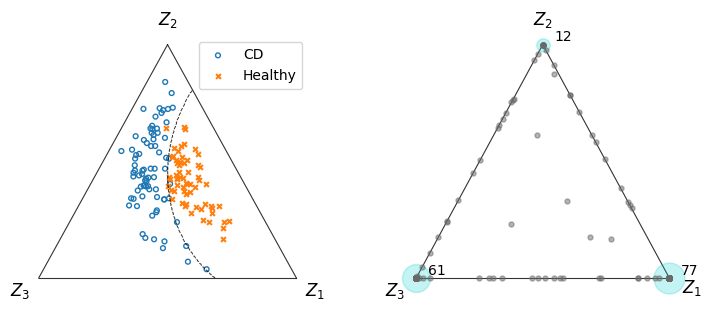

<Figure size 640x480 with 0 Axes>

In [11]:
# Load the result
with open("results/ternary_train/ileum.pkl", "rb") as f:
    result = pickle.load(f)
P = result['CV_fitted_P'].numpy()

gridspec_kw = {'width_ratios': [1, 0.05, 1]}
fig, ax = plt.subplots(1, 3, figsize=(8.5, 3.5), gridspec_kw=gridspec_kw)
ax[1].axis('off') # for spacing between the plots

# From ckdr class, I should extract the class labels
tern_scatter_decbdry(torch.tensor(P), model=result['CV_ckdr_class'], sigma=result['parameters']['sigma_Z'],
                     epsilon=result['parameters']['epsilon'], ax=ax[0], 
                     groups= ['CD', 'Healthy'],
                     marker_list=marker_list, color_list=colors,
                     facecolors='none', linecolor='black', linewidth=0.7)

# Variable allocation plot
_, tax = ternary.figure(scale=1, ax=ax[2])
tax.boundary(linewidth=0.8, alpha=0.8, zorder=1)
tax.scatter(P.T, 
            c="dimgray",
            # c="darkblue", # alpha=0.27 
            marker='o', s=13, alpha=0.5,
             zorder=3)
corner_labeling(tax, offset=[0.1, 0.2, 0.08]) # label the corners (vertices)

# Bubbles for visual indication of overlappings at vertices (90% threshold?)
threshold = 0.9
s = 10
power = 0.9
cluster_dict = {}
for j in range(3):
    # Positions of the columns which lie near the j-th vertex
    pos = np.where(P[j, :] > threshold)[0]
    cluster_dict[j + 1] = taxa.iloc[pos].values  # Store the clustered taxa
    if len(pos) > 0:
        # bubble size
        size = s * len(pos) ** power
        # Vertex position
        vert = np.zeros((1, 3))
        vert[:, j] = 1.0
        # Plot large bubble
        tax.scatter(vert, c="darkturquoise", marker='o', s=size, alpha=0.23, zorder=2)
        # Annotate the number of taxa
        vert = vert + np.array([[0.04, 0.015, -0.02]]) # offset for annotation
        tax.annotate(str(len(pos)), vert.ravel(), fontsize=10, zorder=4
                    #   color=plt.cm.jet(0.95),
                     )

ax[2].set_xlim([-0.06, 1.06]) # ylim adjustment: -0.1, 0.92

# save
# fig.savefig("results/images/ileum.png", dpi=600, bbox_inches='tight')
fig.show()

In [12]:
# Downstream interpretation
cluster_dict = {}

idx_z1 = np.where(P[0, :] > 10 * P[2, :])[0]
idx_z3 = np.where(P[2, :] > 10 * P[0, :])[0]

cluster_dict[1] = taxa.iloc[idx_z1].values
cluster_dict[3] = taxa.iloc[idx_z3].values

# Taxa in the clusters at z1 and z3
cluster_dict

{1: array(['k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium',
        'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides coprocola;t__Bacteroides coprocola DSM 17136',
        'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides;s__Parabacteroides distasonis',
        'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides salyersiae',
        'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides plebeius;t__Bacteroides plebeius DSM 17135',
        'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides stercoris',
        'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae;g__Coprobacter;s__Coprobacter fastidiosus;t__Coprobacter fa

In [13]:
from collections import defaultdict
from reproducibility.table_export import generate_taxa_table, extract_genus_from_taxonomic_string

# Generate the table
output_file = "results/tables/ileum_taxa.tex"
table_content = generate_taxa_table(cluster_dict, output_file, "Ileum", top=100)

# Display detailed summary for debugging
print("\n" + "="*60)
print("DETAILED CLUSTER ANALYSIS:")
print("="*60)
for cluster_id in sorted(cluster_dict.keys()):
    taxa_list = cluster_dict[cluster_id]
    print(f"\nCluster z_{cluster_id}: {len(taxa_list)} taxa")
    
    # Debug: show how each taxon is processed
    genus_counts = defaultdict(int)
    unclassified = []
    
    for taxa_string in taxa_list:
        genus = extract_genus_from_taxonomic_string(taxa_string)
        if genus:
            genus_counts[genus] += 1
        else:
            unclassified.append(taxa_string)
    
    print(f"  - {len(genus_counts)} distinct genera")
    
    # Show top genera
    if genus_counts:
        top_genera = sorted(genus_counts.items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"  - Most abundant: {', '.join([f'{g}({c})' for g, c in top_genera])}")

print(f"\nFinal table generated with {len(table_content)} lines of LaTeX code.")

LaTeX table saved to: results/tables/ileum_taxa.tex

DETAILED CLUSTER ANALYSIS:

Cluster z_1: 89 taxa
  - 51 distinct genera
  - Most abundant: Parabacteroides(5), Eubacterium(5), Roseburia(5), Ruminococcus(5), Bacteroides(4)

Cluster z_3: 77 taxa
  - 52 distinct genera
  - Most abundant: Bacteroides(7), Haemophilus(5), Tyzzerella(3), Lachnoclostridium(3), Dialister(3)

Final table generated with 14 lines of LaTeX code.


# Vaginal Microbiome data (Appendix A)

In [14]:
name = "ravel"
counts = pd.read_csv(directory + name + x_dir, sep='\t')

Y= pd.read_csv(directory + name + y_dir + y_names[name] + ".txt", sep='\t')

counts2 = counts[Y["#SampleID"]]

# Delete taxa present in less than 5 samples
taxa = counts["#OTU ID"][(counts2 > 0).sum(1) >= 5]
counts2 = counts2[(counts2 > 0).sum(1) >= 5]

X = counts2.to_numpy().T
Y = Y["Var"].to_numpy().flatten()

# Normalize
X = X / X.sum(1)[:, None]

print("Zero ratio:", np.sum(X == 0) / X.size)
print("Data shape", X.shape, " with Y ranges", Y.min(), "to", Y.max())

Zero ratio: 0.9146917910766993
Data shape (388, 241)  with Y ranges 0 to 10


In [ ]:
# 6 min with 50 cores
result = ckdr_cv_parallel(X, Y, type_Y=None, folds=5, verbose=False,
                          epsilon_list=[0.001, 0.01],
                          sigma_list=np.geomspace(1/2, 2., 5),
                          n_jobs=50, seed=MASTER_SEED,
                          )

# Save the result
with open("results/ternary_train/vaginal.pkl", "wb") as f:
    pickle.dump(result, f)

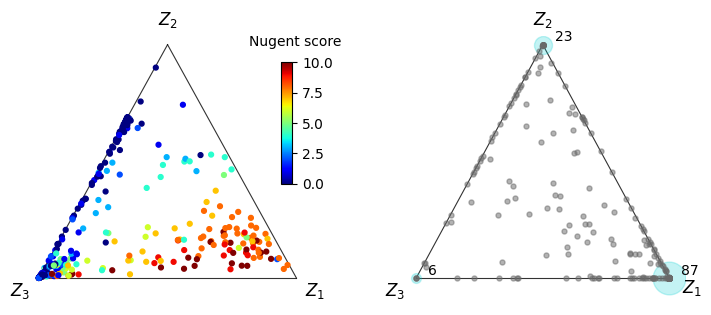

In [ ]:
# Load the result
with open("results/ternary_train/vaginal.pkl", "rb") as f:
    result = pickle.load(f)

P = result['CV_fitted_P'].numpy()
Z = (X @ P.T)

gridspec_kw = {'width_ratios': [1, 0.05, 1]}
fig, ax = plt.subplots(1, 3, figsize=(8.5, 3.5), gridspec_kw=gridspec_kw)
ax[1].axis('off') # Just for spacing between the plots

cmap = plt.cm.jet
tern_scatter_cmap(Z, Y, ax=ax[0], show=False, cmap=cmap, cbar_label="Nugent score", label_position=[-1.3, -35.6])

# Variable allocation plot
_, tax = ternary.figure(scale=1, ax=ax[2])
tax.boundary(linewidth=0.8, alpha=0.8, zorder=1)
tax.scatter(P.T, 
            c="dimgray", 
            # c="darkblue", # alpha=0.27
            marker='o', s=13, alpha=0.5, 
             zorder=3)
corner_labeling(tax, offset=[0.1, 0.2, 0.08]) # label the corners (vertices)

# Bubbles for visual indication of overlappings at vertices (90% threshold?)
threshold = 0.9
s = 10
power = 0.9
cluster_dict = {}
for j in range(3):
    # Positions of the columns which lie near the j-th vertex
    pos = np.where(P[j, :] > threshold)[0]
    cluster_dict[j + 1] = taxa.iloc[pos].values  # Store the clustered taxa
    if len(pos) > 0:
        # bubble size
        size = s * len(pos) ** power
        # Vertex position
        vert = np.zeros((1, 3))
        vert[:, j] = 1.0
        # Plot large bubble
        tax.scatter(vert, c="darkturquoise", marker='o', s=size, alpha=0.23, zorder=2)
        # Annotate the number of taxa
        vert = vert + np.array([[0.04, 0.014, -0.01]]) # offset for annotation
        tax.annotate(str(len(pos)), vert.ravel(), fontsize=10, zorder=4)

ax[2].set_xlim([-0.06, 1.06])

# fig.savefig("results/images/vaginal.png", dpi=600, bbox_inches='tight')
fig.show()

In [ ]:
# Downstream interpretation
cluster_dict = {}

idx_z1 = np.where(P[0, :] > 10 * P[1, :])[0]
idx_z2 = np.where(P[1, :] > 10 * P[0, :])[0]

cluster_dict[1] = taxa.iloc[idx_z1].values
cluster_dict[2] = taxa.iloc[idx_z2].values

# Taxa in the clusters at z1 and z2
cluster_dict

{1: array(['k__Bacteria;p__Actinobacteria;c__Actinobacteria',
        'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces neuii',
        'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinobaculum;s__Actinobaculum massiliense',
        'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces ihumii',
        'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces hongkongensis',
        'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces europaeus',
        'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Actinomyces neuii;t__Actinomyces neuii subsp. anitratus',
        'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetal

In [17]:
# Generate the table
output_file = "results/tables/vaginal_taxa.tex"
table_content = generate_taxa_table(cluster_dict, output_file, "Vaginal", top=15)

# Display detailed summary for debugging
print("\n" + "="*60)
print("DETAILED CLUSTER ANALYSIS:")
print("="*60)
for cluster_id in sorted(cluster_dict.keys()):
    taxa_list = cluster_dict[cluster_id]
    print(f"\nCluster z_{cluster_id}: {len(taxa_list)} taxa")
    
    # Debug: show how each taxon is processed
    genus_counts = defaultdict(int)
    unclassified = []
    
    for taxa_string in taxa_list:
        genus = extract_genus_from_taxonomic_string(taxa_string)
        if genus:
            genus_counts[genus] += 1
        else:
            unclassified.append(taxa_string)
    
    print(f"  - {len(genus_counts)} distinct genera")
    
    # Show top genera
    if genus_counts:
        top_genera = sorted(genus_counts.items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"  - Most abundant: {', '.join([f'{g}({c})' for g, c in top_genera])}")

print(f"\nFinal table generated with {len(table_content)} lines of LaTeX code.")

LaTeX table saved to: results/tables/vaginal_taxa.tex

DETAILED CLUSTER ANALYSIS:

Cluster z_1: 112 taxa
  - 49 distinct genera
  - Most abundant: Prevotella(10), Anaerococcus(10), Corynebacterium(9), Peptoniphilus(7), Actinomyces(6)

Cluster z_2: 56 taxa
  - 30 distinct genera
  - Most abundant: Bacteroides(6), Lactobacillus(5), Streptococcus(5), Staphylococcus(4), Corynebacterium(3)

Final table generated with 14 lines of LaTeX code.
